In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import time


In [2]:

dfB = pd.read_csv("Datasets/spiral.csv",header = 0, sep=";")
XB = dfB.to_numpy()
XB




array([[31.95,  7.95,  3.  ],
       [31.15,  7.3 ,  3.  ],
       [30.45,  6.65,  3.  ],
       [29.7 ,  6.  ,  3.  ],
       [28.9 ,  5.55,  3.  ],
       [28.05,  5.  ,  3.  ],
       [27.2 ,  4.55,  3.  ],
       [26.35,  4.15,  3.  ],
       [25.4 ,  3.85,  3.  ],
       [24.6 ,  3.6 ,  3.  ],
       [23.6 ,  3.3 ,  3.  ],
       [22.75,  3.15,  3.  ],
       [21.85,  3.05,  3.  ],
       [20.9 ,  3.  ,  3.  ],
       [20.  ,  2.9 ,  3.  ],
       [19.1 ,  3.  ,  3.  ],
       [18.2 ,  3.2 ,  3.  ],
       [17.3 ,  3.25,  3.  ],
       [16.55,  3.5 ,  3.  ],
       [15.7 ,  3.7 ,  3.  ],
       [14.85,  4.1 ,  3.  ],
       [14.15,  4.4 ,  3.  ],
       [13.4 ,  4.75,  3.  ],
       [12.7 ,  5.2 ,  3.  ],
       [12.05,  5.65,  3.  ],
       [11.45,  6.15,  3.  ],
       [10.9 ,  6.65,  3.  ],
       [10.3 ,  7.25,  3.  ],
       [ 9.7 ,  7.85,  3.  ],
       [ 9.35,  8.35,  3.  ],
       [ 8.9 ,  9.05,  3.  ],
       [ 8.55,  9.65,  3.  ],
       [ 8.15, 10.35,  3.  ],
       [ 7

In [3]:
dfC = pd.read_csv("Datasets/fig2_panelC.csv",header = 0, sep=";")
XC = dfC.to_numpy()
XC

array([[-0.34576586,  0.7010113 ],
       [-0.34817964,  0.69643325],
       [-0.3435882 ,  0.69923502],
       ...,
       [-0.59184092,  1.26134372],
       [-0.07819092,  0.3031134 ],
       [-0.76162732,  0.38400239]])

<AxesSubplot:title={'center':'Scatter plot of the dataset'}, xlabel='X', ylabel='Y'>

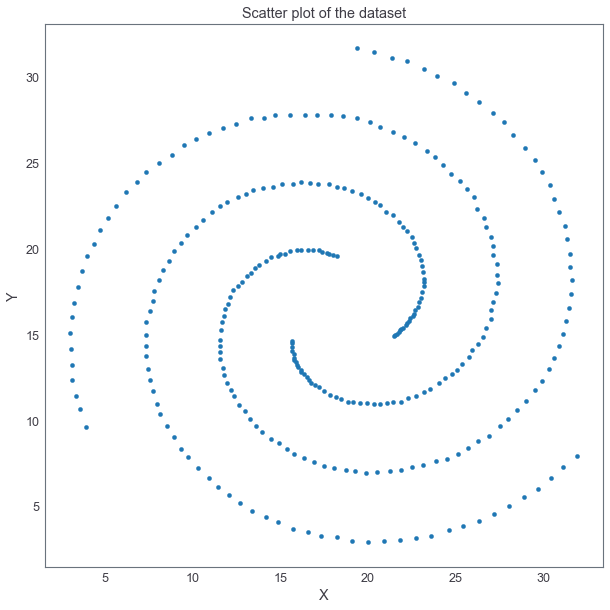

In [4]:
dfB.plot.scatter(x='X',y='Y',c='tab:blue',figsize=(10,10), title='Scatter plot of the dataset')


# Functions

In [5]:

def distance(array, metric ="euclidean"):
    return sklearn.metrics.pairwise_distances(array,metric=metric)
    
def local_density(cutoff, distances): # euclidian distance
    local_density = np.zeros(len(distances))
    for i in range(len(distances)) :
        # calculate the number of points which are closer than cutoff
        local_density[i] = (distances[i] < cutoff).sum()-1 # euclidian distance // -1 to remove self distance
    return local_density

def auto_cutoff(distances) :
    max_cutoff = np.max(distances)
    min_cutoff = np.min(distances)
    cutoff = (max_cutoff+min_cutoff)/2
    while True :
        target =  (distances <= cutoff).sum() / len(distances) ** 2
        if target > 0.01 and target < 0.02 :
            break
        if target < 0.01:
            min_cutoff = cutoff
        else:
            max_cutoff = cutoff
        cutoff = (max_cutoff + min_cutoff) / 2
        if max_cutoff - min_cutoff < 0.0001: 
            break 
    return cutoff

def delta_distance(rho, distances):
    desc_rho_idx = np.argsort(-rho)
    delta,neighbors = [0.0] + [float(np.max(distances))] * (len(distances)-1), [desc_rho_idx[0]] * len(distances)
    desc_distances = distances[desc_rho_idx]
    delta[desc_rho_idx[0]] = -1.
    for i in range(1,len(desc_distances)) : # find the min of pairwise distance for the i-th point from distance array
        filtered_row = desc_distances[i][desc_rho_idx[:i+1]]
        mask_nonzero = np.ma.masked_equal(filtered_row, 0.0, copy=False) # remove distance of 0.0
        delta[desc_rho_idx[i]] = mask_nonzero.min() # find min
        neighbors[desc_rho_idx[i]] = np.where(desc_distances[i] == mask_nonzero.min())[0][0] # find 
        # first index for neighbor
    delta[desc_rho_idx[0]] = max(delta)
    return delta, neighbors
    
def clustering(rho,delta,neighbors, distance_threshold, density_threshold, cutoff) :
    """ Prepare the clusters list and define the centers list"""
    clusters, centers = {}, {} 
    for idx, (density, distance, neighbor) in enumerate(zip(rho, delta, neighbors)):
        if distance * density >= distance_threshold*density_threshold :
            centers[idx] = idx
            clusters[idx] = idx
        else:
            clusters[idx] = -1     
            
    """ Assign each non-center point the cluster of the nearest neighbor """
    desc_rho_idx = np.argsort(-rho)
    for i in range(len(desc_rho_idx)) :
        if clusters[desc_rho_idx[i]] == -1:
            clusters[desc_rho_idx[i]] = clusters[neighbors[desc_rho_idx[i]]]
            
    print(clusters)
    """ Prepare the halo """
    border_rho = {k: 0.0 for k in centers.keys()}
    for i in range(len(rho)-1):
        for j in range(i+1,len(rho)):
            if clusters[i] != clusters[j] and distances[i][j] <= cutoff :
                if clusters[i] == -1 or clusters[j] == -1:
                    continue
                else :
                    if rho[i] > border_rho[clusters[i]]:
                        border_rho[clusters[i]] = rho[i]
                    if rho[j] > border_rho[clusters[j]]:
                        border_rho[clusters[j]] = rho[j]
    for i in range(len(distances)):
        if clusters[i] == -1 :
            clusters[i] = -1000
        elif rho[i] < border_rho[clusters[i]]:
            clusters[i] = -1000 # noise
    return clusters, centers

 

# Processing

In [6]:
""" Compute N x N distances matrix"""
#distances = distance(XB, "l2")
#distances = distance(XB, "manhattan")
start = time.time()
distances = distance(XB)

""" Compute 1 x N local density matrix"""
print("auto_cutoff value is : ",auto_cutoff(distances))
rho = local_density(auto_cutoff(distances), distances)
#rho = local_density(0.051, distances)

""" Compute 1 x N delta matrix"""
delta, neighbors = delta_distance(rho, distances)

""" Compute gamma """
gamma = [a * b for a, b in zip(rho, delta)]

clusters, centers = clustering(rho,delta,neighbors, 5, 5, auto_cutoff(distances))
end = time.time()
print('computation time is :')
print(end - start, "sec")
#{1: 1, 293: 293, 324: 324, 376: 376, 482: 482}

auto_cutoff value is :  0.9476327413613357
{0: 306, 1: 306, 2: 306, 3: 306, 4: 306, 5: 306, 6: 306, 7: 306, 8: 306, 9: 306, 10: 306, 11: 306, 12: 306, 13: 306, 14: 306, 15: 306, 16: 306, 17: 306, 18: 306, 19: 306, 20: 306, 21: 306, 22: 306, 23: 306, 24: 306, 25: 306, 26: 306, 27: 306, 28: 306, 29: 306, 30: 306, 31: 306, 32: 306, 33: 306, 34: 306, 35: 306, 36: 306, 37: 306, 38: 306, 39: 306, 40: 306, 41: 306, 42: 306, 43: 306, 44: 306, 45: 306, 46: 306, 47: 306, 48: 306, 49: 306, 50: 97, 51: 97, 52: 97, 53: 97, 54: 97, 55: 97, 56: 97, 57: 97, 58: 97, 59: 97, 60: 97, 61: 97, 62: 97, 63: 97, 64: 97, 65: 97, 66: 97, 67: 97, 68: 97, 69: 97, 70: 97, 71: 97, 72: 97, 73: 97, 74: 97, 75: 97, 76: 97, 77: 97, 78: 97, 79: 97, 80: 97, 81: 97, 82: 97, 83: 97, 84: 97, 85: 97, 86: 97, 87: 97, 88: 97, 89: 97, 90: 97, 91: 97, 92: 97, 93: 97, 94: 97, 95: 97, 96: 97, 97: 97, 98: 97, 99: 97, 100: 97, 101: 97, 102: 97, 103: 97, 104: 97, 105: 97, 106: -1, 107: -1, 108: -1, 109: -1, 110: -1, 111: -1, 112: -1,

# Decision graph

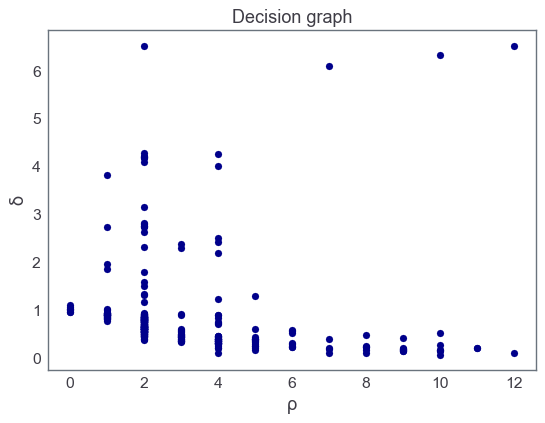

In [7]:
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter(rho,delta, c='Darkblue')
plt.xlabel("ρ")
plt.ylabel("ẟ")
plt.title("Decision graph")
plt.show()

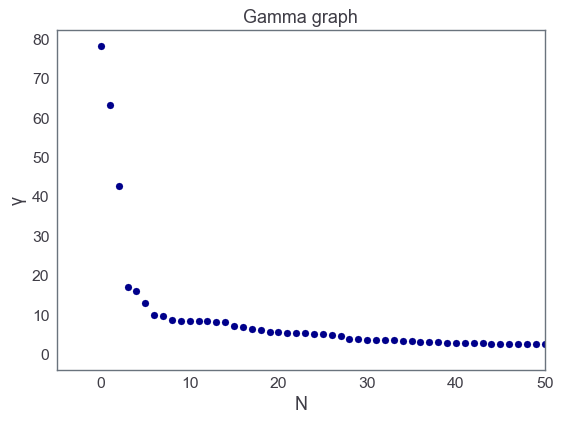

In [8]:
gamma.sort(reverse = True)
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter([i for i in range(len(gamma))], gamma, c='Darkblue')
plt.xlabel("N")
plt.xlim(-5,50)
plt.ylabel("γ")
plt.title("Gamma graph")
plt.show()

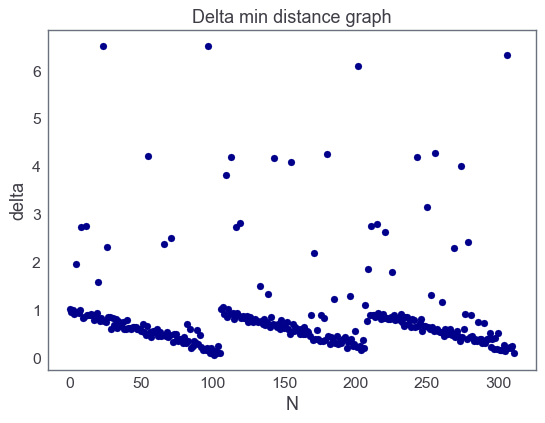

In [9]:
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter([i for i in range(len(delta))], delta, c='Darkblue')
plt.xlabel("N")
#plt.xlim(-5,100)
plt.ylabel("delta")
plt.title("Delta min distance graph")
plt.show()

{-1000: 1000, 97: 2000, 306: 3000, 202: 4000}


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


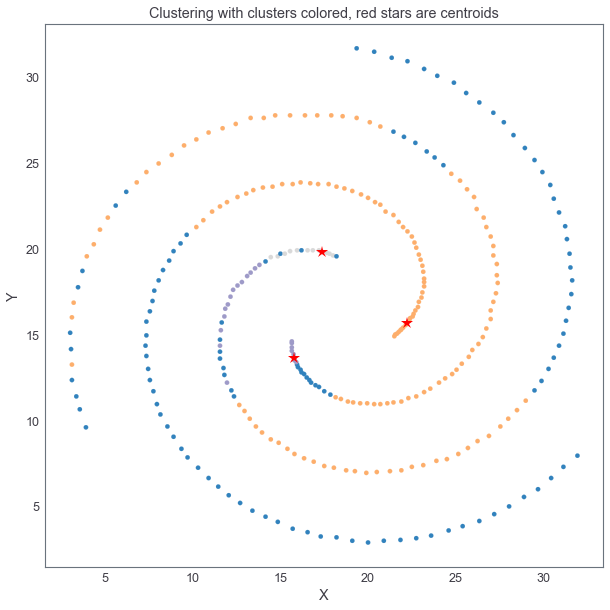

In [10]:
# prepare a dictionnary to assign each cluster a color
new_colors = {}
index = 1000
for element in clusters.values():
    if element in new_colors:
        continue
    else :
        new_colors[element] = index
        index+=1000


print(new_colors)
# plot the final scatter plot, each color represent one cluster
dfB.plot.scatter(x='X',y='Y',
                 color=[new_colors[clusters[i]] for i in clusters],
                 cmap='tab20c',
                 figsize=(10,10),
                 title = 'Clustering with clusters colored, red stars are centroids',
                 #c  = 'g',
                )

# plot the centroid with a red star
X = dfB['X']
Y = dfB['Y']
for idx in enumerate(centers):
    plt.plot(X[idx[1]], Y[idx[1]], 'red', marker = '*', markersize=12)
    if idx[1] == -1000:
        plt.plot(X[idx[0]], Y[idx[0]], color = 'black')
    #plt.text(X[idx[1]], Y[idx[1]], idx)



In [11]:
d = pd.Series(delta)
d.describe()

count    312.000000
mean       0.885155
std        0.987264
min        0.070711
25%        0.427200
50%        0.645156
75%        0.854766
max        6.523994
dtype: float64

In [12]:
print(list(clusters.values()))

[-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, -1000, -1000, 306, -1000, -1000, -1000, -1000, 306, -1000, 306, -1000, 306, 3

In [13]:
print(centers)
print(len(centers), "centers")

{97: 97, 202: 202, 306: 306}
3 centers


computation time is :
0.0024988651275634766 sec
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'DBSCAN clustering'}, xlabel='X', ylabel='Y'>

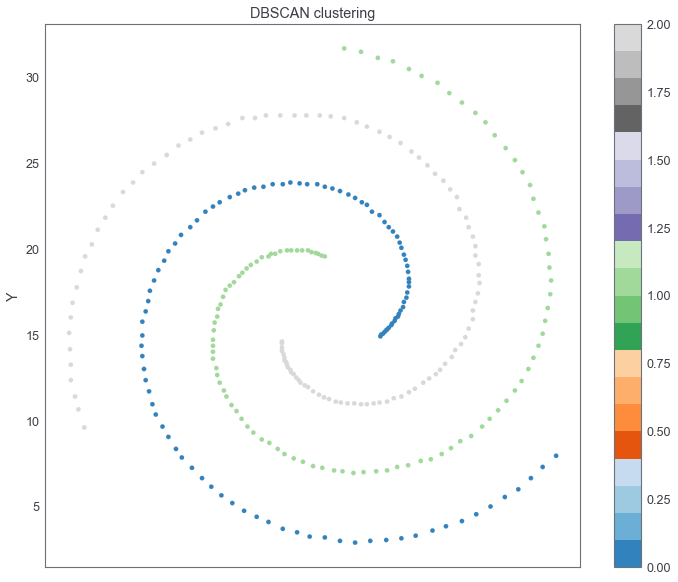

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
start = time.time()
X = StandardScaler().fit_transform(XB)
clustering = DBSCAN(eps=0.5, min_samples=1).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
print(clustering.labels_)

dfB.plot.scatter(x='X',y='Y',
                 color=clustering.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'DBSCAN clustering',
                 #c  = 'g',
                )

computation time is :
1.4020721912384033 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Mean shift clustering'}, xlabel='X', ylabel='Y'>

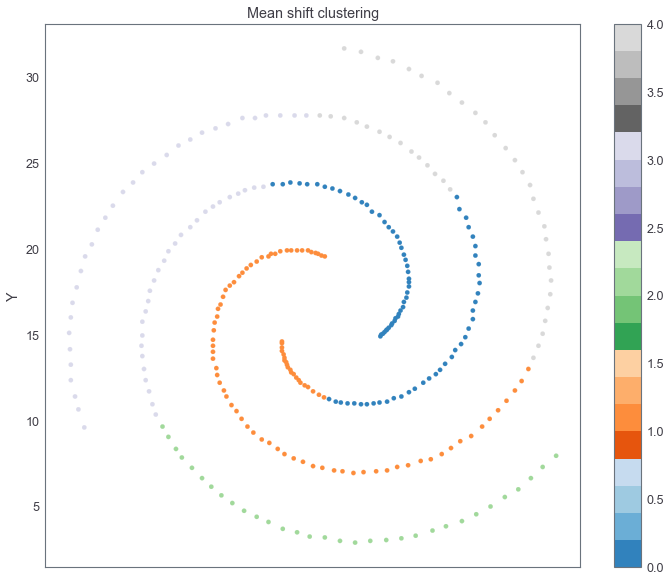

In [15]:
from sklearn.cluster import MeanShift
start = time.time()
X = StandardScaler().fit_transform(XB)
clustering = MeanShift(bandwidth = 1.3).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=clustering.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'Mean shift clustering',
                 #c  = 'g',
                )

computation time is :
0.05199933052062988 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'KMeans clustering with k = 3'}, xlabel='X', ylabel='Y'>

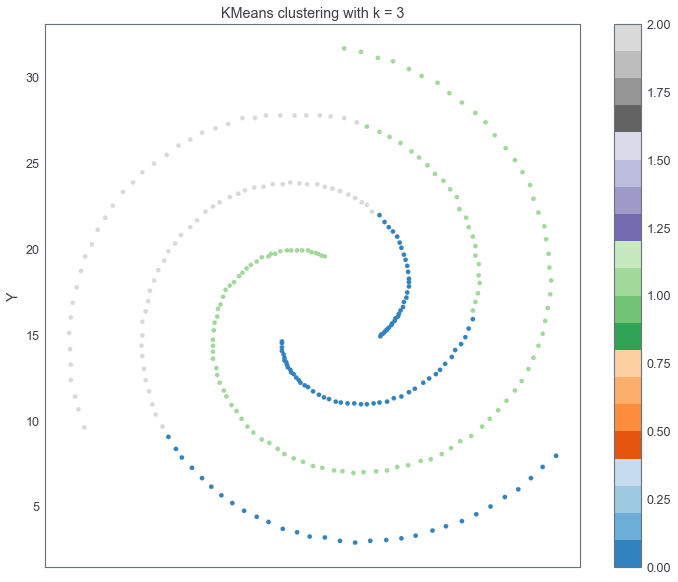

In [16]:
from sklearn.cluster import KMeans

start = time.time()
X = StandardScaler().fit_transform(XB)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=kmeans.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'KMeans clustering with k = 3',
                 #c  = 'g',
                )

computation time is :
0.013498544692993164 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Gaussian mixture clustering with n = 3'}, xlabel='X', ylabel='Y'>

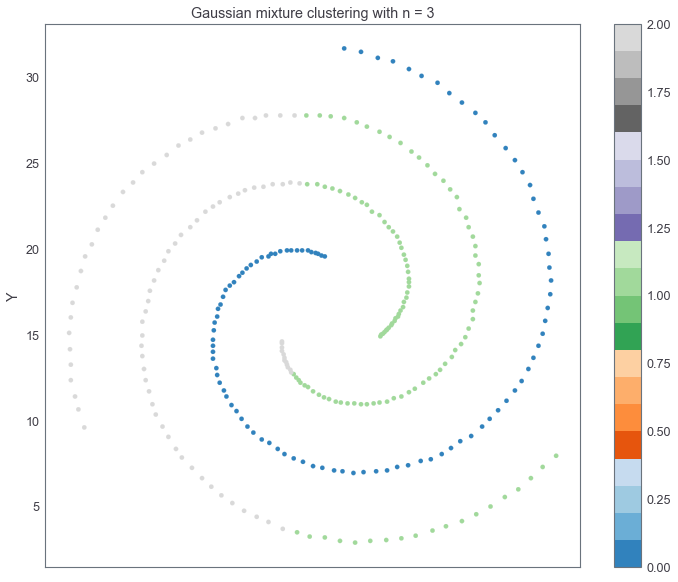

In [17]:
from sklearn.mixture import GaussianMixture

start = time.time()
X = StandardScaler().fit_transform(XB)
gm = GaussianMixture(n_components=3, covariance_type = "diag", random_state=0).fit_predict(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=gm,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'Gaussian mixture clustering with n = 3',
                 #c  = 'g',
                )